In [4]:
import numpy as np
import matplotlib.pyplot as plt 

In [27]:
def itooEuler(f, G, y0, tspan, dt):
    N = len(tspan)
    y = np.zeros((N, 7))
    y[0] = y0;
    for ind,t in enumerate(tspan[:-1]):
        #dW = np.random.normal(0,np.sqrt(dt), (7))
        w0 = np.random.normal()*np.sqrt(dt)
        w1 = np.random.normal()*np.sqrt(dt)
        dW = np.array([w0, w1, w0, w1 , 0.,0.,0.])
        y[ind+1] = y[ind] + f(y[ind], t)*dt + np.dot(G(y[ind], t), dW)
    return y

In [28]:
def Fs(s,t):
    x = s[0:2]
    xdot = np.dot(A,x)
    
    y = s[2:4]
    ydot = np.dot(C,x)
    
    varx, varp,covxp = s[4:]
    
    varx_dot = ((0.5 + n)*gamma) - (varx*gamma) + Lambda - (4*eta*Lambda*covxp**2)  - ((0.5+n)*gamma  + Lambda + (2*varx*np.sqrt(eta*Lambda)))**2 + (2*covxp*omega)
    varp_dot = ((0.5 + n)*gamma) - (varp*gamma) + Lambda - (4*eta*Lambda*covxp**2) -  ((0.5+n)*gamma + Lambda + (2*varp*np.sqrt(eta*Lambda)))**2 - (2*covxp*omega)
    covxp_dot = covxp*(-(4*eta*varp) - (4*varx*eta) - (4*np.sqrt(eta*Lambda))  ) + covxp*gamma*(-1 -2*np.sqrt(eta*Lambda) - (4*n*np.sqrt(eta*Lambda))) + (varp*omega - varx*omega)
        
    return np.array([xdot[0], xdot[1], ydot[0],  ydot[1], varx_dot, varp_dot, covxp_dot])


def s_to_cov(s,begin_cov=4):
    varx, varp,covxy = s[begin_cov:]
    cov = np.array([[varx, covxy], [covxy, varp]])
    return cov


def Gs(s,t):
    cov = s_to_cov(s)
    XiCov = np.dot(cov, C.T) + D.T
    wieners = np.zeros((s.shape[0], s.shape[0]))
    wieners[:2,:2]  = XiCov
    wieners[2:4,2:4] = np.eye(2)
    return wieners

In [29]:
x0 = 0.
p0 = 0.
yx0 = 0.
yp0 = 0.
varx0 = 1.
varp0 = 1.
covxy0 = 0.
s0 = np.array([x0, p0, yx0, yp0, varx0, varp0,covxy0])
np.random.seed(1)


periods = 1
ppp = 10000
dt = 1/ppp
times = np.arange(0.,periods+dt,dt)

eta = 1
gamma = 0.3
Lambda = 0.8
omega = 2*np.pi
n = 10

A = np.array([[-.5*gamma, omega], [-omega, -0.5*gamma]])
D = np.diag([(gamma*(n+0.5)) + Lambda]*2)
C = np.diag([np.sqrt(4*eta*Lambda)]*2)

In [30]:
solutionEuler = itooEuler(Fs, Gs, s0, times, dt)

In [31]:
def convert_solution(ss):
    states = ss[:,0:2]

    signals = ss[:,2:4]
    signals = signals[1:] - signals[:-1]

    covss = ss[:,-3:]
    covs = [s_to_cov(s,begin_cov=0) for s in covss]

    return states, signals, covs

In [32]:
statesEuler, signalsEuler, covsEuler = convert_solution(solutionEuler)

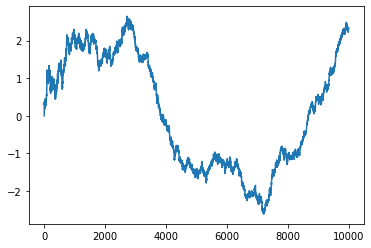

In [33]:
plt.plot(statesEuler[:,0])

Now let's check the Euler using the dy's

In [45]:
from tqdm import tqdm
from misc import ct
xi = lambda cov,D: np.dot(cov, ct(C)) + ct(D)

ExpA = np.array([[np.cos(omega*dt), -np.sin(omega*dt)], [np.sin(omega*dt), np.cos(omega*dt)]])*np.exp(-gamma*dt/2)

def evolve_simu_state(x, xexp, sigma, dy):
    cov = sigma
    XiCov = xi(cov, D)
    dx = np.dot(A-np.dot(XiCov,C),x)*dt   + np.dot(XiCov,dy)
    dxExp = np.dot(ExpA-np.eye(2), xexp) - np.dot(np.dot(XiCov,C), xexp)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov, xexp + dxExp]

sstates = [statesEuler[0]]
sstatesExp = [statesEuler[0]]
scovs = [covsEuler[0]]

for ind,dy in enumerate(tqdm(signalsEuler)):
    simu = evolve_simu_state(sstates[-1], sstatesExp[-1], scovs[-1], dy)
    sstates.append(simu[0])
    scovs.append(simu[1])#[ind+1])
    sstatesExp.append(simu[2])

100%|██████████| 10000/10000 [00:00<00:00, 26809.64it/s]


In [50]:
A

array([[-0.15      ,  6.28318531],
       [-6.28318531, -0.15      ]])

In [51]:
ExpA - np.eye(2)

array([[-1.51972766e-05, -6.28309065e-04],
       [ 6.28309065e-04, -1.51972766e-05]])

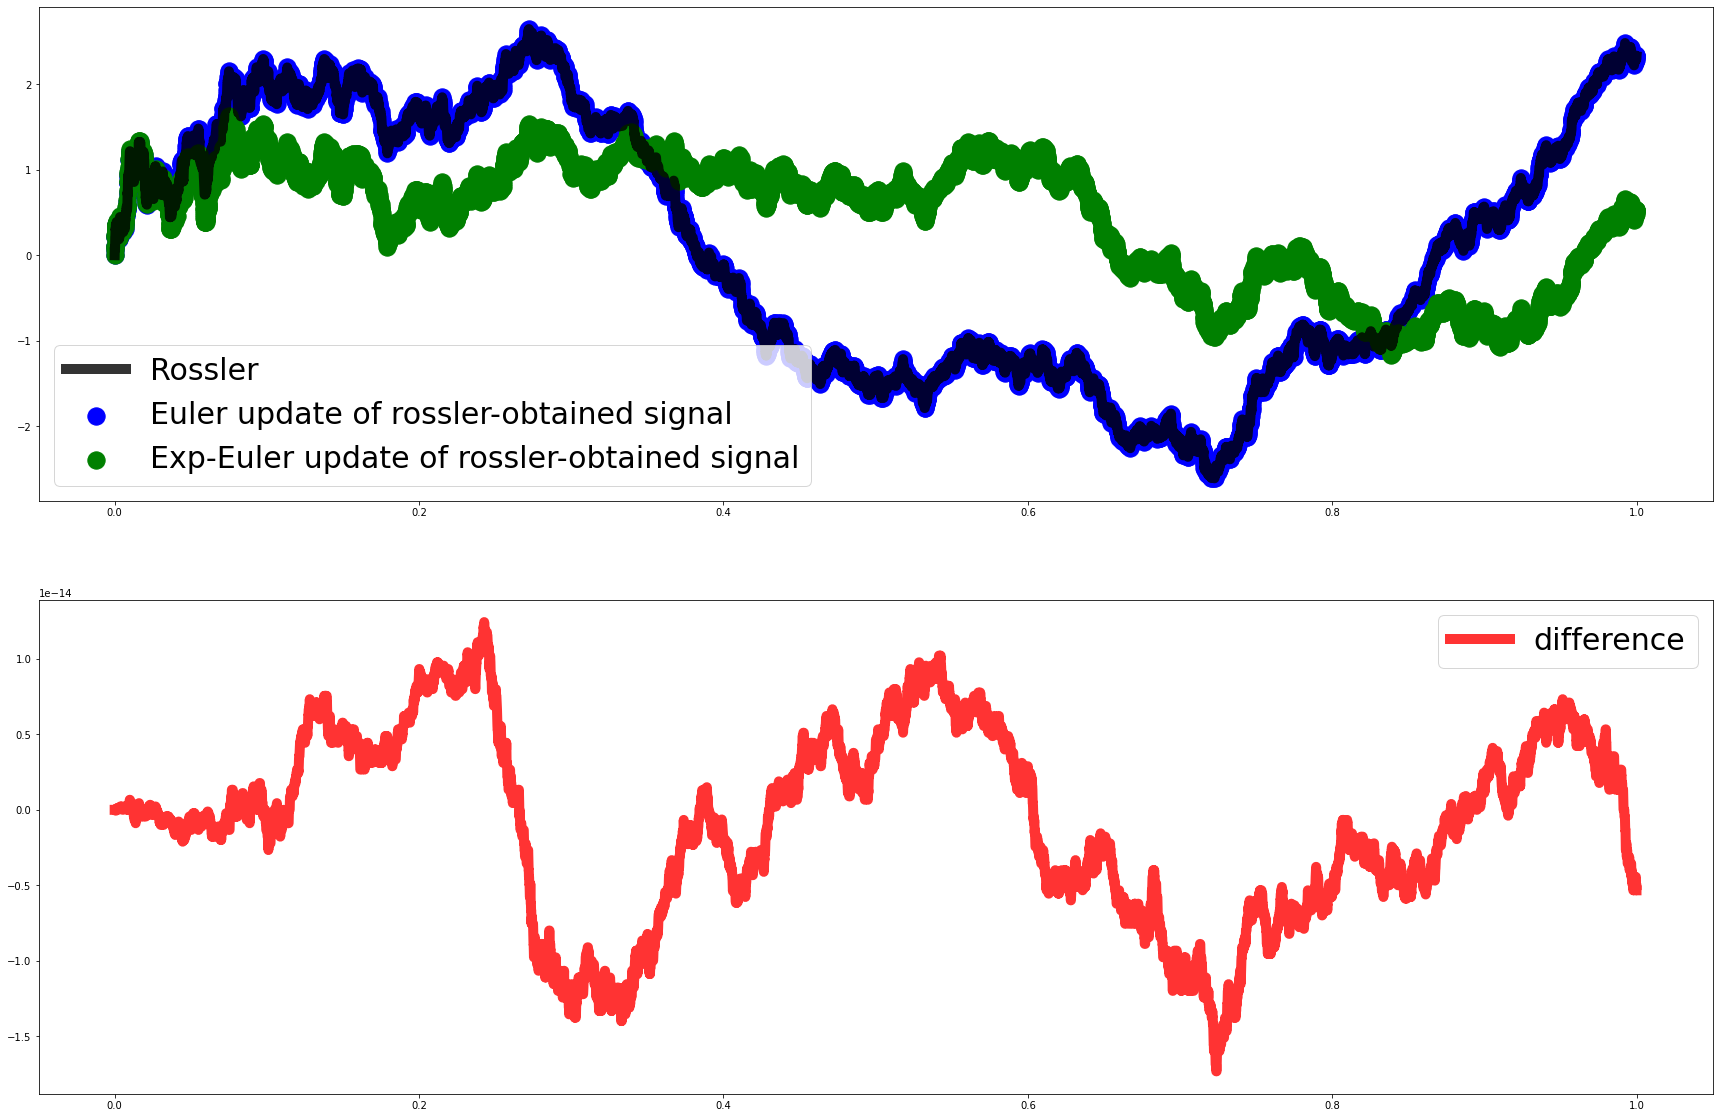

In [53]:
plt.figure(figsize=(30,20))
T=-1
plt.subplot(211)
plt.scatter(times[:T],np.array(sstates)[:,0][:T], s=300,color="blue", label="Euler update of rossler-obtained signal")
plt.scatter(times[:T],np.array(sstatesExp)[:,0][:T], s=300,color="green", label="Exp-Euler update of rossler-obtained signal")

plt.plot(times[:T],statesEuler[:,0][:T],color="black", linewidth=10, alpha=.8,label="Rossler")
plt.legend(prop={"size":30})
plt.subplot(212)
plt.plot(times[:T],statesEuler[:,0][:T]-np.array(sstates)[:,0][:T],color="red", linewidth=10, alpha=.8, label="difference")
#plt.plot(times[:T],statesEuler[:,0][:T]-np.array(sstatesExp)[:,0][:T],color="red", linewidth=10, alpha=.8, label="difference Exp")

plt.legend(prop={"size":30})